### Import necessary libraries:

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### A Convolutional Variational Autoencoder (VAE) with encoder-decoder architecture.

In [7]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(256)

        self.conv_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.conv_logvar = nn.Linear(256 * 2 * 2, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 2 * 2)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debatch_norm1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.debatch_norm2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.debatch_norm3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 2, 2)
        x = self.leaky_relu(self.debatch_norm1(self.deconv1(x)))
        x = self.leaky_relu(self.debatch_norm2(self.deconv2(x)))
        x = self.leaky_relu(self.debatch_norm3(self.deconv3(x)))
        x = self.tanh(self.deconv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### A Fully Connected Variational Autoencoder (VAE) with fully connected layers.

In [8]:
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        self.fc_mu = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)

        # Latent to hidden
        self.z_fc = nn.Linear(latent_dim, hidden_dim * 4)

        # Decoder
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        h1 = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        h2 = F.leaky_relu(self.fc2(h1), negative_slope=0.2)
        h3 = F.leaky_relu(self.fc3(h2), negative_slope=0.2)
        mu = self.fc_mu(h3)
        logvar = self.fc_logvar(h3)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.leaky_relu(self.z_fc(z), negative_slope=0.2)
        h = F.leaky_relu(self.fc4(h), negative_slope=0.2)
        h = F.leaky_relu(self.fc5(h), negative_slope=0.2)
        x_recon = torch.tanh(self.fc6(h))  
        return x_recon.view(-1, 3072)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


### Loss function

In [9]:
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

def loss_function_fcvae(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 3072), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

### Training the VAE

In [10]:
num_epochs = 15
lr = 0.0001
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'cvae':
                loss_function = loss_function_cvae
            elif model_name == 'fcvae':
                loss_function = loss_function_fcvae
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

### Train the Models

#### Train the Convolutional VAE

In [11]:
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=64, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [00:19<00:00, 40.04batch/s, kld_loss=37.8, recon_loss=402, train_loss=440]  


Epoch 1/15 train loss: 440.0476364160156 mse loss: 402.2925683203125 kld loss: 37.75506885009766


Epoch 2: 100%|██████████| 782/782 [00:19<00:00, 40.85batch/s, kld_loss=44.8, recon_loss=229, train_loss=274]  


Epoch 2/15 train loss: 273.71117904296875 mse loss: 228.94382533203125 kld loss: 44.76735388427734


Epoch 3: 100%|██████████| 782/782 [00:18<00:00, 41.59batch/s, kld_loss=46, recon_loss=199, train_loss=245]     


Epoch 3/15 train loss: 244.75730181640625 mse loss: 198.72137239746093 kld loss: 46.03592940917969


Epoch 4: 100%|██████████| 782/782 [00:19<00:00, 40.00batch/s, kld_loss=47.3, recon_loss=185, train_loss=232]  


Epoch 4/15 train loss: 232.2223140966797 mse loss: 184.9011425 kld loss: 47.321171801757814


Epoch 5: 100%|██████████| 782/782 [00:18<00:00, 41.98batch/s, kld_loss=48.7, recon_loss=176, train_loss=225]  


Epoch 5/15 train loss: 224.5668234765625 mse loss: 175.8554137158203 kld loss: 48.711409924316406


Epoch 6: 100%|██████████| 782/782 [00:18<00:00, 41.67batch/s, kld_loss=50, recon_loss=169, train_loss=219]    


Epoch 6/15 train loss: 219.34199224609375 mse loss: 169.30834686523437 kld loss: 50.033644995117186


Epoch 7: 100%|██████████| 782/782 [00:18<00:00, 41.94batch/s, kld_loss=51.3, recon_loss=163, train_loss=214]  


Epoch 7/15 train loss: 214.42618590820314 mse loss: 163.0853531640625 kld loss: 51.34083279785156


Epoch 8: 100%|██████████| 782/782 [00:18<00:00, 41.36batch/s, kld_loss=52.4, recon_loss=158, train_loss=211]  


Epoch 8/15 train loss: 210.73681663085938 mse loss: 158.3263815673828 kld loss: 52.41043517944336


Epoch 9: 100%|██████████| 782/782 [00:19<00:00, 40.95batch/s, kld_loss=53.2, recon_loss=155, train_loss=209]  


Epoch 9/15 train loss: 208.543277890625 mse loss: 155.29515758789063 kld loss: 53.248120529785155


Epoch 10: 100%|██████████| 782/782 [00:18<00:00, 42.31batch/s, kld_loss=53.9, recon_loss=152, train_loss=206]   


Epoch 10/15 train loss: 206.375958515625 mse loss: 152.4477159765625 kld loss: 53.928242561035155


Epoch 11: 100%|██████████| 782/782 [00:17<00:00, 43.61batch/s, kld_loss=54.5, recon_loss=150, train_loss=205]  


Epoch 11/15 train loss: 204.5103400048828 mse loss: 150.05357795898436 kld loss: 54.456762010498046


Epoch 12: 100%|██████████| 782/782 [00:18<00:00, 42.15batch/s, kld_loss=54.9, recon_loss=148, train_loss=203]   


Epoch 12/15 train loss: 203.12291541015625 mse loss: 148.2213820605469 kld loss: 54.901532966308594


Epoch 13: 100%|██████████| 782/782 [00:18<00:00, 42.74batch/s, kld_loss=55.4, recon_loss=146, train_loss=202]   


Epoch 13/15 train loss: 201.596325 mse loss: 146.21117740234374 kld loss: 55.385147502441406


Epoch 14: 100%|██████████| 782/782 [00:18<00:00, 41.38batch/s, kld_loss=55.7, recon_loss=145, train_loss=201]   


Epoch 14/15 train loss: 200.77730677734374 mse loss: 145.0684485546875 kld loss: 55.708857980957035


Epoch 15: 100%|██████████| 782/782 [00:33<00:00, 23.30batch/s, kld_loss=56, recon_loss=144, train_loss=200]    

Epoch 15/15 train loss: 199.61716127929688 mse loss: 143.6020994140625 kld loss: 56.015061911621096


#### Train the Fully Connected VAE

In [12]:
transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=64, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=1000, latent_dim=128).to(device)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [00:16<00:00, 46.24batch/s, kld_loss=11, recon_loss=128, train_loss=139]    


Epoch 1/15 train loss: 138.53721385009766 mse loss: 127.50393132324218 kld loss: 11.033282455444336


Epoch 2: 100%|██████████| 782/782 [00:11<00:00, 65.27batch/s, kld_loss=11.9, recon_loss=88.9, train_loss=101]   


Epoch 2/15 train loss: 100.7926865209961 mse loss: 88.92768897949219 kld loss: 11.86499754699707


Epoch 3: 100%|██████████| 782/782 [00:17<00:00, 45.08batch/s, kld_loss=12.7, recon_loss=81.5, train_loss=94.1]  


Epoch 3/15 train loss: 94.141124453125 mse loss: 81.4651024609375 kld loss: 12.676022014160155


Epoch 4: 100%|██████████| 782/782 [00:17<00:00, 45.14batch/s, kld_loss=13.1, recon_loss=77.7, train_loss=90.7]  


Epoch 4/15 train loss: 90.73944803710937 mse loss: 77.65781374511718 kld loss: 13.081634298095704


Epoch 5: 100%|██████████| 782/782 [00:12<00:00, 63.88batch/s, kld_loss=13.6, recon_loss=74.5, train_loss=88.1] 


Epoch 5/15 train loss: 88.10413199707031 mse loss: 74.45784859863281 kld loss: 13.646283334960938


Epoch 6: 100%|██████████| 782/782 [00:11<00:00, 68.16batch/s, kld_loss=14.2, recon_loss=72.1, train_loss=86.3]  


Epoch 6/15 train loss: 86.2997465209961 mse loss: 72.1220353125 kld loss: 14.177711137390137


Epoch 7: 100%|██████████| 782/782 [00:11<00:00, 69.78batch/s, kld_loss=14.6, recon_loss=70.7, train_loss=85.4] 


Epoch 7/15 train loss: 85.35173329589844 mse loss: 70.71897360839844 kld loss: 14.6327595993042


Epoch 8: 100%|██████████| 782/782 [00:11<00:00, 70.30batch/s, kld_loss=15.3, recon_loss=68.8, train_loss=84.1]  


Epoch 8/15 train loss: 84.1103053515625 mse loss: 68.8283840234375 kld loss: 15.28192118560791


Epoch 9: 100%|██████████| 782/782 [00:11<00:00, 66.28batch/s, kld_loss=16, recon_loss=67, train_loss=83]       


Epoch 9/15 train loss: 82.95161814697266 mse loss: 66.95994469970704 kld loss: 15.991673359985352


Epoch 10: 100%|██████████| 782/782 [00:11<00:00, 68.09batch/s, kld_loss=16.5, recon_loss=65.6, train_loss=82.1] 


Epoch 10/15 train loss: 82.08284856933594 mse loss: 65.63137373779297 kld loss: 16.451474852905275


Epoch 11: 100%|██████████| 782/782 [00:11<00:00, 69.20batch/s, kld_loss=17, recon_loss=64.3, train_loss=81.3]   


Epoch 11/15 train loss: 81.310093125 mse loss: 64.34770368652343 kld loss: 16.96238946044922


Epoch 12: 100%|██████████| 782/782 [00:11<00:00, 65.72batch/s, kld_loss=17.3, recon_loss=63.6, train_loss=80.8]  


Epoch 12/15 train loss: 80.82321424804688 mse loss: 63.554674921875 kld loss: 17.268539396972656


Epoch 13: 100%|██████████| 782/782 [00:11<00:00, 66.81batch/s, kld_loss=17.5, recon_loss=62.9, train_loss=80.3] 


Epoch 13/15 train loss: 80.33564420410156 mse loss: 62.85745436035156 kld loss: 17.478189904174805


Epoch 14: 100%|██████████| 782/782 [00:11<00:00, 67.22batch/s, kld_loss=17.7, recon_loss=62.2, train_loss=79.9] 


Epoch 14/15 train loss: 79.85337104003906 mse loss: 62.18502030029297 kld loss: 17.668350675048828


Epoch 15: 100%|██████████| 782/782 [00:12<00:00, 64.30batch/s, kld_loss=17.9, recon_loss=61.6, train_loss=79.4] 

Epoch 15/15 train loss: 79.44051221679688 mse loss: 61.557350825195314 kld loss: 17.88316140258789


### Generate & View Images

In [30]:
def generate_images(model, arg, num_images=20, latent_dim=20):
    model.eval() 
    device = next(model.parameters()).device
    with torch.no_grad():  # Turn off gradients for generation
        z = torch.randn(num_images, latent_dim).to(device)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    if generated_images.dim() == 2 and generated_images.shape[1] == 3072:  
        generated_images = generated_images.view(-1, 3, 32, 32)  # Reshape to 3x32x32 RGB images
        
    if arg == 'yes':
        # Rescale the images to the range [-1, 1]
        generated_images = (generated_images + 1) / 2

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].permute(1, 2, 0).numpy())
        axs[i].axis('off')
    plt.show()

Fully Connected VAE - Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0041698585..0.76676023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059262935..0.7182555].


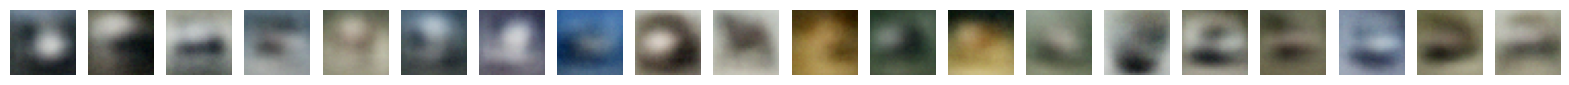

Convolutional VAE - Images


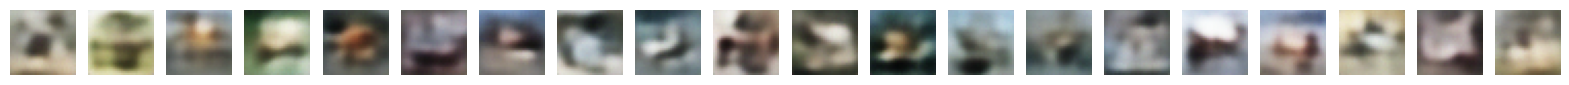

In [31]:
print('Fully Connected VAE - Images')
generate_images(fcvae, 'no', latent_dim=128)

print('Convolutional VAE - Images')
generate_images(cvae, 'yes', latent_dim=128)

In [33]:
def interpolate_images(model, model_name, image1, image2, device, num_steps=20):
    model.eval()
    with torch.no_grad():
        if model_name == 'cvae':
            if image1.shape[1] == 1:
                image1 = image1.repeat(1, 3, 1, 1)
            if image2.shape[1] == 1:
                image2 = image2.repeat(1, 3, 1, 1)
        image1 = image1.to(device)
        image2 = image2.to(device)
        mu1, logvar1 = model.encode(image1)
        mu2, logvar2 = model.encode(image2)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            interpolated_z = alpha * z2 + (1 - alpha) * z1
            reconstructed_image = model.decode(interpolated_z).cpu()
            if model_name == 'cvae':
                reconstructed_image = (reconstructed_image + 1) / 2
            interpolated_images.append(reconstructed_image)
        interpolated_images = torch.cat(interpolated_images, dim=0)
        return torch.clamp(interpolated_images, 0, 1)

In [34]:
def visualize_interpolation(model, model_name, dataset, num_steps=20):
    data_iter = iter(dataset)
    image1, _ = next(data_iter)
    image2, _ = next(data_iter)
    image1 = image1.unsqueeze(0).to(device)  
    image2 = image2.unsqueeze(0).to(device)  
    
    if image1.shape[1] == 1:
        image1 = image1.repeat(1, 3, 1, 1) 
    if image2.shape[1] == 1:
        image2 = image2.repeat(1, 3, 1, 1) 
    
    interpolated_images = interpolate_images(model, model_name, image1, image2, device, num_steps=num_steps)

    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        image = interpolated_images[i]
        
        if image.shape[-1] == 3072:  
            image = image.view(3, 32, 32)  

        if image.ndimension() == 3 and image.shape[0] == 3: 
            image = image.permute(1, 2, 0) 
        
  
        if image.ndimension() == 2:  
            image = image.cpu().numpy()  
        elif image.ndimension() == 3 and image.shape[2] == 3: 
            image = image.cpu().numpy() 

        axs[i].imshow(image)  
        axs[i].axis('off') 
    plt.show()

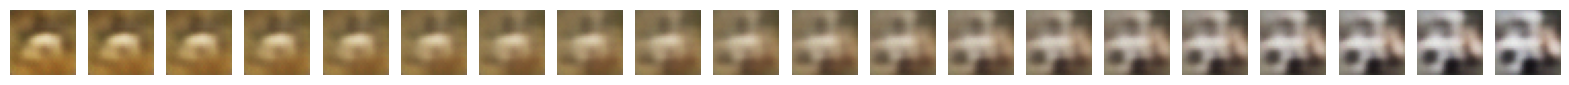

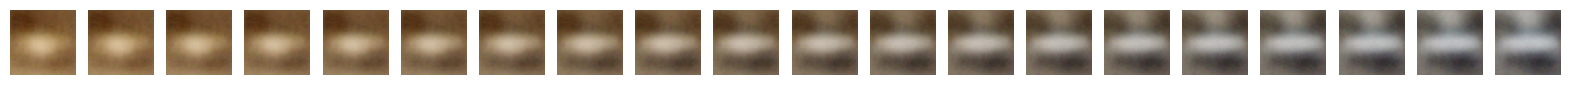

In [36]:
visualize_interpolation(cvae, 'cvae', train_dataset_cvae, num_steps=20)

visualize_interpolation(fcvae, 'fcvae', train_dataset_fcvae, num_steps=20)